In [1]:
from policy_mining import PolicyMining
import pandas as pd
import numpy as np
import networkx as nx
from auxiliar_functions.data_preprocessing import add_new_index
from auxiliar_functions.network_model import build_network_model, bipartite_projection, plot_distribution_degree
from auxiliar_functions.community_detection import sub_community_detection, add_type_commts
from auxiliar_functions.rule_inference import frequent_resources, get_attrs_from_user_sig, get_attrs_from_user, get_attrs_from_res, attribute_value_common, evaluate_weight
from auxiliar_functions.evaluation import get_FN_logs, get_FP_logs, get_FP_logs_ref, get_FN_logs_ref
from auxiliar_functions.refinement import generate_negative_rules
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

In [2]:
NAME_DATASET = "IoT"
FILE_NAME = "../00-Data/IoT-amz-paper-rw-2.csv"
USER_ATTRS = ['role', 'AgeRange', 'health']
RESOURCE_ATTRS = ["type", "area", "mode", "tempRange", "lockstatus"]

In [3]:
df_data = pd.read_csv(FILE_NAME)
df_data = df_data[df_data.columns[1:]]
df_data.rname = df_data.rname + 123 # Cambiar el identificador para que no haya el mismo ID

bins_age = [0, 10, 18, 35, 65, np.inf]
names_age = ['<10', '10-18', '18-35', '35-65', '65+']
df_data['AgeRange'] = pd.cut(df_data['age'], bins_age, labels=names_age)
del df_data["age"]

bins_temp = [-10, 0, 10, 20, 30, np.inf]
names_temp = ["-10-0", "0-10", "10-20", "20-30", "30-40"]
df_data["tempRange"] = pd.cut(df_data["temperature"], bins_temp, labels=names_temp)
del df_data["temperature"]

df_data = df_data.drop_duplicates()
df_data

,role,health,uname,type,area,mode,lockstatus,rname,ACTION,AgeRange,tempRange
0,child,health,0,Lights,livingroom,armed,locked,723,0,<10,0-10
1,child,health,0,Lights,livingroom,night,locked,765,0,<10,-10-0
2,child,health,0,TV,backyard,night,unlocked,1098,1,<10,0-10
3,child,health,0,TV,backyard,night,unlocked,1106,0,<10,20-30
4,child,health,0,Lights,bedroom,disarmed,unlocked,824,1,<10,30-40
...,...,...,...,...,...,...,...,...,...,...,...
227713,guest,emergency,122,Lights,backyard,armed,locked,851,0,10-18,-10-0
227808,guest,emergency,122,TV,livingroom,night,locked,967,1,10-18,0-10
230038,guest,emergency,122,Thermostats,backyard,armed,locked,453,1,10-18,NaN
230996,guest,emergency,122,Thermostats,livingroom,disarmed,locked,359,0,10-18,20-30


In [5]:
name_ds = NAME_DATASET
print("File loaded! \n")

cross_validation_settings = {
    "k": 10,
    "id_k": 0,
    "test_size": 0.2,
    "random_state": 1
}

# Cross-Validation
if cross_validation_settings["random_state"] != None:  # With random state
    kfold = StratifiedShuffleSplit(n_splits=cross_validation_settings["k"],
                                   test_size=cross_validation_settings["test_size"],
                                   random_state=cross_validation_settings["random_state"])
else:
    kfold = StratifiedShuffleSplit(n_splits=cross_validation_settings["k"],
                                   test_size=cross_validation_settings["test_size"])

data_partition = kfold.split(df_data, df_data.ACTION)
data_corpus = []  # List with all data partitions

for train_data, test_data in data_partition:
    X_train, X_test = df_data.iloc[train_data], df_data.iloc[test_data]
    data_corpus.append([X_train, X_test])

print("Cross-Validation - DONE")
print("- k =", cross_validation_settings["k"])
print("- Percentage Train-Test:",
      (1-cross_validation_settings["test_size"])*100, "-",
      cross_validation_settings["test_size"]*100)

# Selection of a split with the id_k ID.
df_train_k = data_corpus[cross_validation_settings["id_k"]][0]
df_test_k = data_corpus[cross_validation_settings["id_k"]][1]

print("# Access requests in Train:", len(df_train_k),
      " %: {:.2f}".format((len(df_train_k)/(len(df_train_k)+len(df_test_k)))*100))
print("# Access requests in Test:", len(df_test_k),
      " %: {:.2f}".format((len(df_test_k)/(len(df_train_k)+len(df_test_k)))*100))
print("# Access requests:", len(df_train_k)+len(df_test_k))
print()

File loaded! 

Cross-Validation - DONE
- k = 10
- Percentage Train-Test: 80.0 - 20.0
# Access requests in Train: 44015  %: 80.00
# Access requests in Test: 11004  %: 20.00
# Access requests: 55019



In [105]:
### 1. Preprocessing

# Task 1: Hanfling missing and null values.
# NA

# Task 2: Converting continuous values to categorical values.
# NA

# Task 3: Removing duplicated access requests.
df_train_k_pos = df_train_k[df_train_k.ACTION == 1]
df_train_k_neg = df_train_k[df_train_k.ACTION == 0]
# print(self.df_train_k_pos.columns[1:])
df_train_k_pos = df_train_k_pos.drop_duplicates()
df_train_k_neg = df_train_k_neg.drop_duplicates()

print("# (+) access requests:", len(df_train_k_pos),
      " %: {:.2f}".format((len(df_train_k_pos)/len(df_train_k))*100))

print("# (-) access requests:", len(df_train_k_neg),
      " %: {:.2f}".format((len(df_train_k_neg)/len(df_train_k))*100))

print("TASK 3: Done!\n")

# (+) access requests: 21858  %: 49.66
# (-) access requests: 22157  %: 50.34
TASK 3: Done!



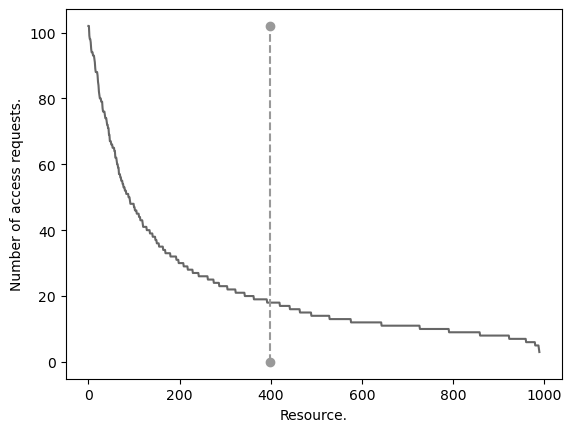

In [112]:
###### Tarea 4: recursos más frecuentes
res_to_freq = (df_train_k_pos.rname.value_counts()).to_dict()
res_to_freq_lists = res_to_freq.items()
x_list, y_list = zip(*res_to_freq_lists)
#plt.figure(figsize=(20,15))
plt.plot(y_list, color='0.40', linestyle='-')
# plt.plot(141,8, marker="o", color="red")
plt.ylabel('Number of access requests.')
plt.xlabel('Resource.')
n_corte_recursos = 399
x1, y1 = [n_corte_recursos, n_corte_recursos] , [0, max(y_list)]
plt.plot(x1, y1, marker = 'o', linestyle='--', color="0.6")
#plt.text(n_corte_recursos+100, 5, '{}'.format(n_corte_recursos) , ha='left', va= 'top')
#plt.savefig('frec-res-iot-corte.png')
plt.show()

In [113]:
###### ***** TASK 4 ***** #####
# Selecting the most used resources.
n1 = 0
n2 = n_corte_recursos
#n2 = 399
top_list = df_train_k_pos.rname.value_counts()[:len(
    df_train_k_pos.rname.drop_duplicates())].index.tolist()
# Filter the interval between n1 and n2
top_list = top_list[n1:n2+1]
boolean_series = df_train_k_pos.rname.isin(top_list)
df_train_k_pos = df_train_k_pos[boolean_series]
bolean_series = df_train_k_neg.rname.isin(top_list)
df_train_k_neg = df_train_k_neg[bolean_series]
print("TASK 4: Done!\n")

TASK 4: Done!



In [114]:
### Fase 2
print("\n#########################")
print(" PHASE 2: Network Model.")
print("#########################\n")

###### ***** TASK 1 ***** #####
# Access request bipartite network
bip_network = build_network_model(df_train_k_pos, 'uname', 'rname')
print("TASK 1: Done!\n")

###### ***** TASK 2 ***** #####
# User network 3
user_network = bipartite_projection(bip_network, 0)

# Complex Network Analysis
avg_degree = sum(user_network.degree()) / user_network.vcount()
print("\nNetwork Analysis")
print("- Avg. degree", "{:.4f}".format(avg_degree))

print("- Density:", "{:.4f}".format(user_network.density()))

cc = user_network.transitivity_avglocal_undirected()
print("- Clustering Coefficient:", "{:.4f}".format(cc))

L = user_network.average_path_length()
print("- Average Path Length :", "{:.4f}".format(L))

#plot_distribution_degree(user_network, name_ds)
print("TASK 2: Done!\n")



#########################
 PHASE 2: Network Model.
#########################

ARBN builded!
IGRAPH UN-- 520 15308 -- 
+ attr: name (v), typen (v)
|U-Nodes| = 120
|R-Nodes| = 400
TASK 1: Done!

User Network builded!
IGRAPH UNW- 120 7140 -- 
+ attr: name (v), rsrcs (v), weight (e)

Network Analysis
- Avg. degree 119.0000
- Density: 1.0000
- Clustering Coefficient: 1.0000
- Average Path Length : 1.0000
TASK 2: Done!



In [121]:
#from collections import OrderedDict
weight_to_remove = 0.3
edges_to_remove = user_network.es.select(weight_lt=weight_to_remove)
len(edges_to_remove)

1794

IGRAPH UNW- 120 47 -- 
+ attr: commty (v), name (v), rsrcs (v), tpcommty (v), weight (e)

Network Analysis
- Avg. degree 0.7833
- Density: 0.0066
- Clustering Coefficient: 0.2962
- Average Path Length : 2.7883
TASK 2: Done!



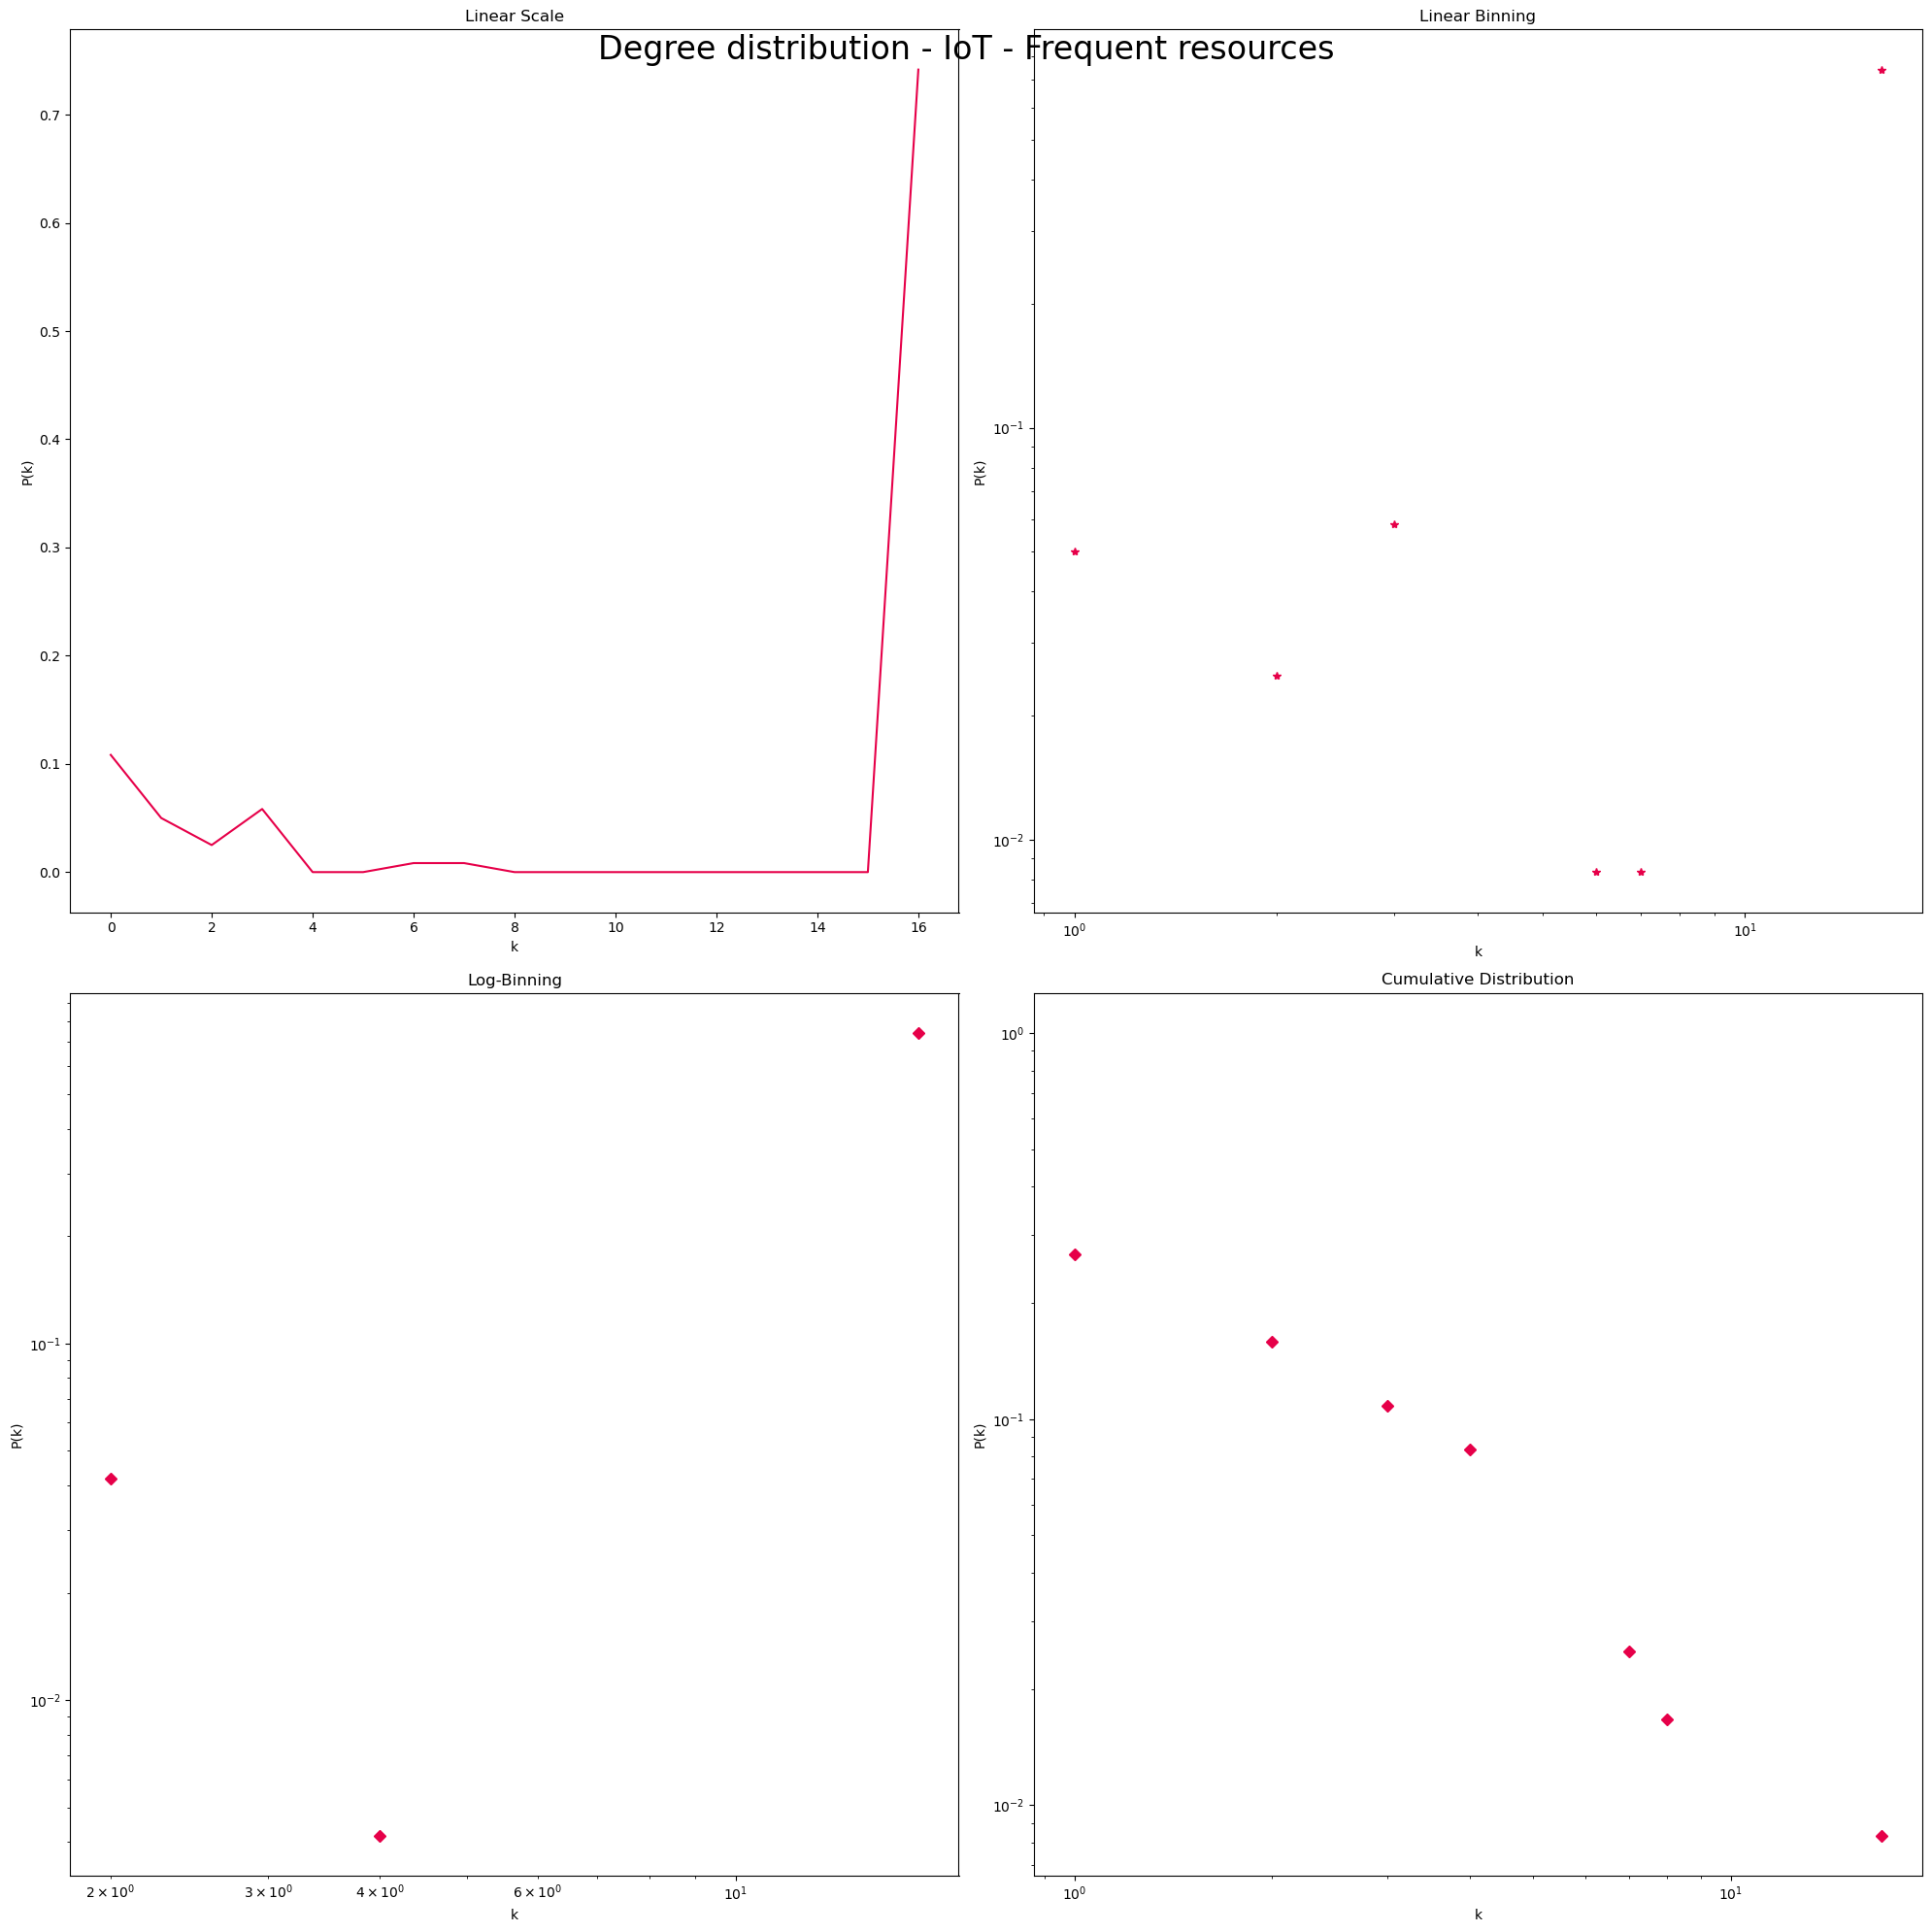

In [122]:
edges_to_remove = user_network.es.select(weight_lt=weight_to_remove)
user_network.delete_edges(edges_to_remove)
print(user_network.summary())

# Complex Network Analysis
avg_degree = sum(user_network.degree()) / user_network.vcount()
print("\nNetwork Analysis")
print("- Avg. degree", "{:.4f}".format(avg_degree))

print("- Density:", "{:.4f}".format(user_network.density()))

cc = user_network.transitivity_avglocal_undirected()
print("- Clustering Coefficient:", "{:.4f}".format(cc))

L = user_network.average_path_length()
print("- Average Path Length :", "{:.4f}".format(L))

plot_distribution_degree(user_network, name_ds)
print("TASK 2: Done!\n")


In [123]:
print("\n###############################")
print(" PHASE 3: Community Detection.")
print("###############################\n")

###### ***** TASK 1 ***** #####
# Community detection
partition = user_network.community_multilevel(
    weights=user_network.es()["weight"])

# Modularity score
print("Modularity: %.4f" % partition.modularity)

# Add cluster attribute
user_network.vs["commty"] = partition.membership

print(user_network.summary())
print(partition.summary())
print("TASK 1: Done!\n")

dict_commts = sub_community_detection(
    user_network, 0.5, None)

###### ***** TASK 2 ***** #####
# Community calssification
n_res_in_comms = [len(i[1]) for i in dict_commts.values()]
max_n_res = max(n_res_in_comms)
# print("Comunidad con # mayor recursos", max_n_res)

# Sparse and Med Thresholds
big_threshold = int(0.50 * max_n_res)
med_threshold = int(0.25 * max_n_res)
print("Big Threshold: ", big_threshold,
      " \t\t Med Threshold", med_threshold)

s_commts, m_commts, c_commts = add_type_commts(user_network, dict_commts,
                                               big_threshold, med_threshold)
all_commts = s_commts + m_commts + c_commts
print("TASK 2: Done!\n")



###############################
 PHASE 3: Community Detection.
###############################

Modularity: 0.3937
IGRAPH UNW- 120 47 -- 
+ attr: commty (v), name (v), rsrcs (v), tpcommty (v), weight (e)
Clustering with 120 elements and 94 clusters
TASK 1: Done!

Big Threshold:  182  		 Med Threshold 91
|C|: 96 == 96
Sparse Comms: 8
Medium Comms: 53
Concentrate Comms: 35
TASK 2: Done!



In [261]:
commty_to_analyze = all_commts[21]
new_data = df_train_k_pos.rname.isin(commty_to_analyze[1][1])
new_data = df_train_k_pos[new_data]
new_datA = new_data[RESOURCE_ATTRS].drop_duplicates()
init_Sup = 0.5
init_Conf = 0.8
_, rules = apriori(new_data.values.tolist(), minSup=init_Sup, minConf=init_Conf)  # Apply apriori
rules

[[{1}, {'TV'}, 0.8212002474737059],
 [{'backyard'}, {'TV'}, 0.8716012084592145],
 [{'backyard'}, {1, 'TV'}, 0.8716012084592145],
 [{1, 'backyard'}, {'TV'}, 0.8716012084592145],
 [{'TV'}, {1}, 1.0],
 [{'backyard'}, {1}, 1.0],
 [{'unlocked'}, {1}, 1.0],
 [{'TV', 'backyard'}, {1}, 1.0]]

In [201]:
commty_to_analyze[1][0].vs["name"]

[73, 84, 52, 38, 17, 33, 71]

In [203]:
new_data = df_train_k_pos.uname.isin(commty_to_analyze[1][0].vs["name"])
new_data = df_train_k_pos[new_data]
new_data = new_data[USER_ATTRS].drop_duplicates()
_, rules = apriori(new_data.values.tolist(), minSup=init_Sup, minConf=init_Conf)  # Apply apriori
rules

[]

In [262]:
#df_train_k_pos.rename(columns = {'uname':'UID', 'rname': 'RID'}, inplace = True) 

In [66]:
from collections import Counter
from apriori_python import apriori

def remove_equal_rulesX(rules):
    rules = [set(r[:-1]) for r in rules]

    a = []
    for r in rules:
        if not r in a:
            a.append(r)

    max_id = 0
    to_ret = None
    for i in a:
        if len(i) > max_id:
            max_id = len(i)
            to_ret = i

    return [to_ret]
def frequent_resources(subcomunidad, grafo_bip, umbral):
    """Retorna los recursos nuevos ya podados."""
    usuario_comunidad = subcomunidad.vs()["name"]
    all_recursos = []  # DIccionario con los recursos y su frecuencia
    for user in usuario_comunidad:
        user_node = grafo_bip.vs.find(name=user)
        vecinos_recurso = user_node.neighbors()
        vecinos_recurso = [node["name"] for node in vecinos_recurso]
        vecinos_recurso = list(set(vecinos_recurso))
        # print(vecinos_recurso)
        all_recursos = all_recursos + vecinos_recurso

    umbral_en_n = int(umbral * subcomunidad.vcount())

    all_recursos = dict(Counter(all_recursos))

    frequent_resources = [id_res for (
        id_res, value_) in all_recursos.items() if value_ >= umbral_en_n]

    if len(frequent_resources) == 0:
        frequent_resources = [id_res for (id_res, value_) in all_recursos.items(
        ) if value_ >= max(all_recursos.values())]

    return frequent_resources


def get_attrs_from_res(data_, res_attr, resources):
    df_res_commty = data_[data_["rname"].isin(resources)]
    df_res_commty = df_res_commty[res_attr].drop_duplicates()

    return df_res_commty


def get_attrs_from_user(commty_network, data_, user_attr, resources, bip_network):
    users_commty = commty_network.vs["name"]
    df_users_commty = data_[data_["uname"].isin(users_commty)]
    df_users_commty = data_[data_["rname"].isin(resources)]
    df_users_commty = df_users_commty[user_attr+["uname"]].drop_duplicates()

    return df_users_commty


def get_attrs_from_user_sig(commty_network, data_, user_attr, sig_resource, bip_network):
    users_commty = commty_network.vs["name"]
    user_access_sig_resource = bip_network.vs.find(name=sig_resource)
    user_access_sig_resource = user_access_sig_resource.neighbors()
    user_access_sig_resource = [node["name"]
                                for node in user_access_sig_resource]
    users_commty = list(
        set(user_access_sig_resource).intersection(set(users_commty)))
    df_users_commty = data_[data_["uname"].isin(users_commty)]
    df_users_commty = df_users_commty[user_attr+["uname"]].drop_duplicates()
    return df_users_commty


def get_attr_name_by_value(value, data_):
    # value = list(value)[0]
    for attr in data_.columns:
        if value in list(data_[attr].drop_duplicates()):
            return attr
    return None

def attribute_value_common2(data_):
    """Retorna regla apriori basada en los recursos.
    data_: dataframe
    """
    init_Sup = 0.6
    init_Conf = 0.8
    rules = []
    while len(rules) == 0:
        #print("Sup", init_Sup, "  Conf", init_Conf)
        _, rules = apriori(data_.values.tolist(), minSup=init_Sup,
                           minConf=init_Conf)  # Apply apriori
        init_Sup -= 0.1
        init_Conf -= 0.1

        if init_Sup < 0.001:
            #break
            #return [[],{},1]
            rules = [[set(data_.values[0][:-1]), {}, 1]]            
            #print("a")
            break
    
    if len(rules) == 0:
        return None
    
    rules = [list(r[0])+list(r[1])+[r[-1]] for r in rules]
    rules = remove_equal_rulesX(rules)
    rules = [list(r) for r in rules]
    #print(rules)

    reglas_karimi = []
    for r in rules:
        for t in r:
            col = get_attr_name_by_value(t, data_)
            reglas_karimi.append([col, t])

    return reglas_karimi

In [32]:
import random

# Definir una lista de ejemplo
lista_ejemplo = [['lockstatus', 'locked'], ['type', 'TV'], ['tempRange', '20-30'], ['area', 'backyard']]

# Definir el número de elementos a elegir aleatoriamente
n = int(len(lista_ejemplo)/2)

# Elegir aleatoriamente n elementos de la lista
elementos_aleatorios = random.sample(lista_ejemplo, n)

# Imprimir los elementos elegidos aleatoriamente
print("Elementos aleatorios elegidos:", elementos_aleatorios)


Elementos aleatorios elegidos: [['lockstatus', 'locked'], ['tempRange', '20-30']]


In [124]:
print("\n##########################")
print(" PHASE 4: Rule Inference.")
print("##########################\n")

###### ***** TASK 1 ***** #####
# Rule extraction
list_rules = []  # Lista de reglas
th_lfr = 1
th_sr = 1

for commty_ in all_commts:
    commty_resources = commty_[1][1]  # Get resources
    # print()

    if commty_[1][2] != 2:

        commty_resources = frequent_resources(commty_[1][0], bip_network, th_lfr)        

        # print("TIPO 3 SIG:", commty_significant_res)

        if len(commty_resources) < 1:
            continue
        # print("TIPO 3 RESTA:", commty_resources)

    # Create the other rule
    # Se comienza generando la regla.
    rule_i = [["id_com", str(commty_[0])], []]
    
    df_res_commty = get_attrs_from_res(
        df_train_k_pos, RESOURCE_ATTRS, commty_resources)
    #print(df_res_commty)
    rule_res_attrs = attribute_value_common2(df_res_commty)
    
    if len(rule_res_attrs) > int(len(RESOURCE_ATTRS)/2):
        rule_res_attrs = random.sample(rule_res_attrs, int(len(RESOURCE_ATTRS)/2))
    #print(rule_res_attrs)    
    if rule_res_attrs != None:
        rule_i[1] = rule_i[1] + rule_res_attrs

    # Atributos frecuentes en usuarios
    df_users_commty = get_attrs_from_user(
        commty_[1][0], df_train_k_pos, USER_ATTRS,
        commty_resources, bip_network)
    # print(df_users_commty.values[0])
    rule_user_attrs = attribute_value_common2(df_users_commty)
    if len(rule_user_attrs) > int(len(USER_ATTRS)/2):
        rule_user_attrs = random.sample(rule_user_attrs, int(len(USER_ATTRS)/2))
    if rule_user_attrs != None:
        rule_i[1] = rule_i[1] + rule_user_attrs
        list_rules.append(rule_i)
print("|R|:", len(list_rules))
print("TASK 1: Done!\n")


##########################
 PHASE 4: Rule Inference.
##########################

|R|: 96
TASK 1: Done!



In [104]:
list_rules, len(list_rules)

([[['id_com', '1'], [['area', 'backyard'], ['type', 'TV'], ['role', 'user']]],
  [['id_com', '2'], [['type', 'TV'], ['area', 'backyard'], ['role', 'user']]],
  [['id_com', '3'],
   [['mode', 'night'], ['area', 'backyard'], ['AgeRange', '65+']]],
  [['id_com', '4'],
   [['area', 'backyard'], ['type', 'TV'], ['health', 'emergency']]],
  [['id_com', '5'],
   [['area', 'backyard'], ['lockstatus', 'locked'], ['AgeRange', '35-65']]],
  [['id_com', '7'], [['mode', 'night'], ['type', 'TV'], ['role', 'guest']]],
  [['id_com', '10'],
   [['type', 'TV'], ['area', 'backyard'], ['AgeRange', '65+']]],
  [['id_com', '11'],
   [['type', 'TV'], ['area', 'backyard'], ['health', 'emergency']]],
  [['id_com', '12'],
   [['type', 'TV'], ['area', 'backyard'], ['AgeRange', '65+']]],
  [['id_com', '16'],
   [['type', 'TV'], ['area', 'backyard'], ['role', 'guest']]],
  [['id_com', '6'],
   [['lockstatus', 'locked'], ['type', 'TV'], ['role', 'user']]],
  [['id_com', '8'],
   [['type', 'TV'], ['area', 'backyard'

In [134]:
###### ***** TASK 2 ***** #####
# Rule Network
th_rule_sim = 0
rules_with_idx = {}
for idx, rule in enumerate(list_rules):
    rules_with_idx[idx] = rule

# Create the graph
edge_list = []
for idxA in range(len(list_rules)):
    for idxB in range(idxA, len(list_rules)):
        edge_temp = evaluate_weight(
            rules_with_idx[idxA][1], rules_with_idx[idxB][1],
            th_rule_sim)
        if edge_temp != -1:
            edge_list.append((idxA, idxB, edge_temp))

rule_network = nx.Graph()
rule_network.add_weighted_edges_from(edge_list)

# Add rule attribute
rule_network.remove_edges_from(
    nx.selfloop_edges(rule_network))

# print(self.rule_network.nodes, len(self.rule_network.nodes))
# print(self.rules_with_idx.keys(), len(self.rules_with_idx.keys()))
isolated_nodes = [
    i for i in rules_with_idx.keys() if i not in rule_network.nodes]
# print(isolated_nodes, len(isolated_nodes))
rule_network.add_nodes_from(isolated_nodes)

print("Rule Network\n", nx.info(rule_network))
print("TASK 2: Done!\n")

Rule Network
 Name: 
Type: Graph
Number of nodes: 96
Number of edges: 4560
Average degree:  95.0000
TASK 2: Done!



In [133]:
len(list_rules)

96

In [135]:
print("\n#############")
print(" Evaluation.")
print("#############\n")
#df_train_k_pos.rename(columns = {'uname':'UID', 'rname': 'RID'}, inplace = True)
#df_train_k_pos.rename(columns = {'UID':'uname', 'RID':'rname'}, inplace = True) 
###### ***** TASK 1 ***** #####
# Get False Negative Set
fn_logs = get_FN_logs(df_train_k_pos, user_network, list_rules, rule_network, rules_with_idx)


#############
 Evaluation.
#############



In [136]:
# Get False Positive Set

fp_logs = get_FP_logs(df_train_k_neg, user_network, list_rules, rule_network, rules_with_idx)

TP = len(df_train_k_pos) - len(fn_logs)
TN = len(df_train_k_neg) - len(fp_logs)

precision = TP / (TP + len(fp_logs))

recall = TP / (TP + len(fn_logs))

fscore = 2*(precision*recall)/(precision+recall)

print("FN:", len(fn_logs),
      " - {:.2f}%".format((len(fn_logs)/len(df_train_k_pos))*100))
print("FP:", len(fp_logs),
      " - {:.2f}%".format((len(fp_logs)/len(df_train_k_neg))*100))
print("Precision:", precision)
print("Recall:", recall)
print("F-score", fscore)

# computing Weighted Complexity Score (WSC)
wsc = sum([len(rule[1]) for rule in list_rules])

print("# Rules:", len(list_rules))
print("WSC:", wsc)

FN: 5120  - 33.45%
FP: 2  - 0.01%
Precision: 0.9998037291462217
Recall: 0.6655343611183695
F-score 0.7991214997254688
# Rules: 96
WSC: 288


In [19]:
len(df_train_k_pos), len(df_train_k_neg)

(21858, 22157)

In [63]:
TP = 16300
TN = 16034

precision = TP / (TP + 1225)

recall = TP / (TP + 1402)

fscore = 2*(precision*recall)/(precision+recall)
#print("FN:", 3681,
#      " - {:.2f}%".format((len(fn_logs)/len(df_train_k_pos))*100))
#print("FP:", 2760,
#      " - {:.2f}%".format((len(fp_logs)/len(df_train_k_neg))*100))
print("Precision:", precision)
print("Recall:", recall)
print("F-score", fscore)

Precision: 0.9300998573466477
Recall: 0.9207999096147328
F-score 0.9254265194311182


P6: Scale-free distribution p(k) = ∼k^{−α}.


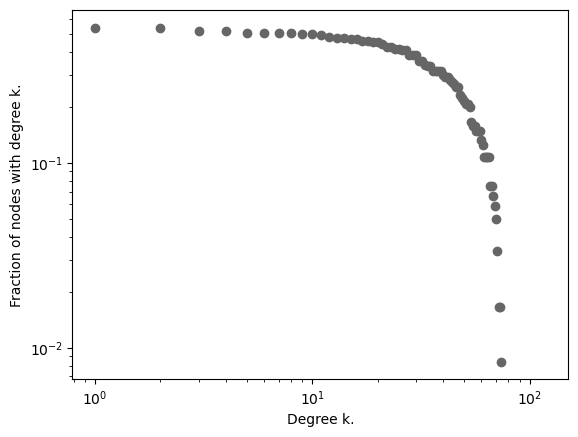

In [290]:
##### P6: Scale-free distribution p(k) = ∼k−α. #####
print("P6: Scale-free distribution p(k) = ∼k^{−α}.")
distri_grados = [i/user_network.vcount() for i in user_network.degree()]
#plt.figure(figsize=(20,15))
plt.plot(sorted(distri_grados,reverse=True),linestyle='', marker='o', color="0.4")

#x2, y2 = [1, 231], [3, 2]
# plt.plot(x1, y1, marker = 'o')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Degree k.')
plt.ylabel('Fraction of nodes with degree k.')
plt.savefig('degree-distri-iot.pdf')
plt.show()